In [61]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from prfpy_csenf.csenf_plot_functions import *
from dag_prf_utils.prfpy_functions import *
from dag_prf_utils.prfpy_ts_plotter import *
from dag_prf_utils.plot_functions import *
from dag_prf_utils.utils import *
from dag_prf_utils.pycortex import *


from amb_scripts.load_saved_info import *
from amb_scripts.plot_functions import *
plot_cols = get_plot_cols()

p2plot_nice = {
    'nothingrois' : 'ROI borders',
    'sfmax': 'SF_{max} (c/deg)',
    'aulcsf': 'normalized AUC (%)',
    'SFp': 'SF_p (c/deg)',
    'CSp': 'CS_p (a.u.)',
    'crf_exp': 'slope_{crf} (a.u.)',
    'rsq' : 'variance explained (%)',
    'ecc' : 'eccentricity (deg)',
    'size_1' : 'size',
}

sub_list = ['sub-02']
ses_list = ['ses-1', 'ses-2']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


sub-02 only

[1] ecc vs size. 2 x 3 (ses 1,3, roi V1,V2,V3)

[2] Time series gauss. LE & RE. V1 (+color)

[3] Surfaces ses - eye - ecc,pol,PRF rsq

[4] qCSF Before & after 

...
[5] ncsf 



In [62]:
# START LOGGING THIS NOTEBOOK
import figure_finder as ff
out_file = '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/notebook_timeline/'
if not os.path.exists(out_file):
    os.mkdir(out_file)
name = f'EMC_figures_2024-03-19'
fig_saver = ff.FigureSaver(
    name            = name,
    path            = out_file,
    save_mode       = True, 
    fig_overwrite   = 'ow',     
    save_svg_w_code = False,
    save_svg  = False,
    save_png  = True,
    save_pdf  = True,
    folder_ow = True,
    )


FOLDER ALREADY EXISTS!
Deleting and remaking folder


# Load saved info

#### Load qCSF

In [63]:

qCSF_info = {}
for sub in sub_list:
    qCSF_info[sub] = {}
    for ses in ses_list:
        try: 
            qCSF_info[sub][ses] = amb_load_qcsf(sub, eye_list=['L', 'R'], ses=ses)
        except:
            print(f'failed {sub} {ses}')
            qCSF_info[sub][ses] = []


#### Load run correlation (akin to rsq ceiling)

In [64]:
run_corr = {}
for sub in sub_list:
    run_corr[sub] = {}
    for i_ses,ses in enumerate(ses_list):   
        for model in ['gauss', 'csf']:
            for eye in ['L', 'R']:
                if model=='gauss':
                    task = f'pRF{eye}E'
                else:
                    task = f'CSF{eye}E'
                try:
                    run_corr[sub][f'{eye}_{i_ses+1}_{model}'] = amb_load_run_corr(
                        sub=sub,
                        task_list=task,
                        ses=ses,
                    )[task]
                except:                
                    run_corr[sub][f'{eye}_{i_ses+1}_{model}'] = []
                    print(f'{sub} {task} failed')

In [65]:
# Load prfpy_stim
prfpy_stim = {}
prfpy_stim['gauss'] = amb_load_prfpy_stim('pRF')
prfpy_stim['csf'] = amb_load_prfpy_stim('CSF')

prfpy_model = {}
prfpy_model['gauss'] = Iso2DGaussianModel(stimulus=prfpy_stim['gauss'])
prfpy_model['csf'] = CSenFModel(stimulus=prfpy_stim['csf'])
prfpy_model['csf_bin'] = CSenFModel(stimulus=prfpy_stim['csf'], edge_type='binary')

Number of timepoints: 214
Number of unique SF levels: 6, [ 0.5  1.   3.   6.  12.  18. ]
Number of unique CON levels: 14, [ 0.25   0.39   0.607  0.946  1.475  2.299  3.582  5.583  8.701 13.56
 21.134 32.937 51.332 80.   ]


In [66]:
roi_fit = 'all'
fit_stage='iter'

model_list = ['gauss', 'csf']
prf_multi = {}

for sub in sub_list:
    prf_obj_list = [] 
    prf_id_list = []
    for i_ses,ses in enumerate(ses_list):        
        for eye in ['L', 'R']:    
            for model in model_list:
                if 'csf' in model:
                    task = f'CSF{eye}E'
                else:
                    task = f'pRF{eye}E'

                this_prf_data = amb_load_prf_params(
                    sub=sub,
                    task_list=task,
                    model_list=model,
                    roi_fit=roi_fit, 
                    fit_stage=fit_stage,
                    ses=ses
                )[task][model]
                this_real_ts = amb_load_real_tc(sub=sub, task_list=task, ses=ses)[task]
                

                if model=='csf':
                    this_obj = CSenFPlotter(
                        prf_params=this_prf_data,
                        real_ts = this_real_ts,                        
                        prfpy_model = prfpy_model['csf'],
                    )
                else:
                    this_obj = TSPlotter(
                        prf_params=this_prf_data,
                        real_ts = this_real_ts,                        
                        model='gauss',
                        prfpy_model = prfpy_model['gauss'],
                    )

                prf_obj_list.append(this_obj)
                prf_id_list.append(f'{eye}_{i_ses+1}_{model}')   
            
    prf_multi[sub] = PrfMulti(prf_obj_list, prf_id_list)

prf_params.shape[-1]=8
include hrf = True
include rsq = True
prf_params.shape[-1]=10
hrf=params[:,7,8], rsq=params[:,9]
prf_params.shape[-1]=8
include hrf = True
include rsq = True
prf_params.shape[-1]=10
hrf=params[:,7,8], rsq=params[:,9]
prf_params.shape[-1]=8
include hrf = True
include rsq = True
prf_params.shape[-1]=10
hrf=params[:,7,8], rsq=params[:,9]
prf_params.shape[-1]=8
include hrf = True
include rsq = True
prf_params.shape[-1]=10
hrf=params[:,7,8], rsq=params[:,9]


# ECC vs SIZE 

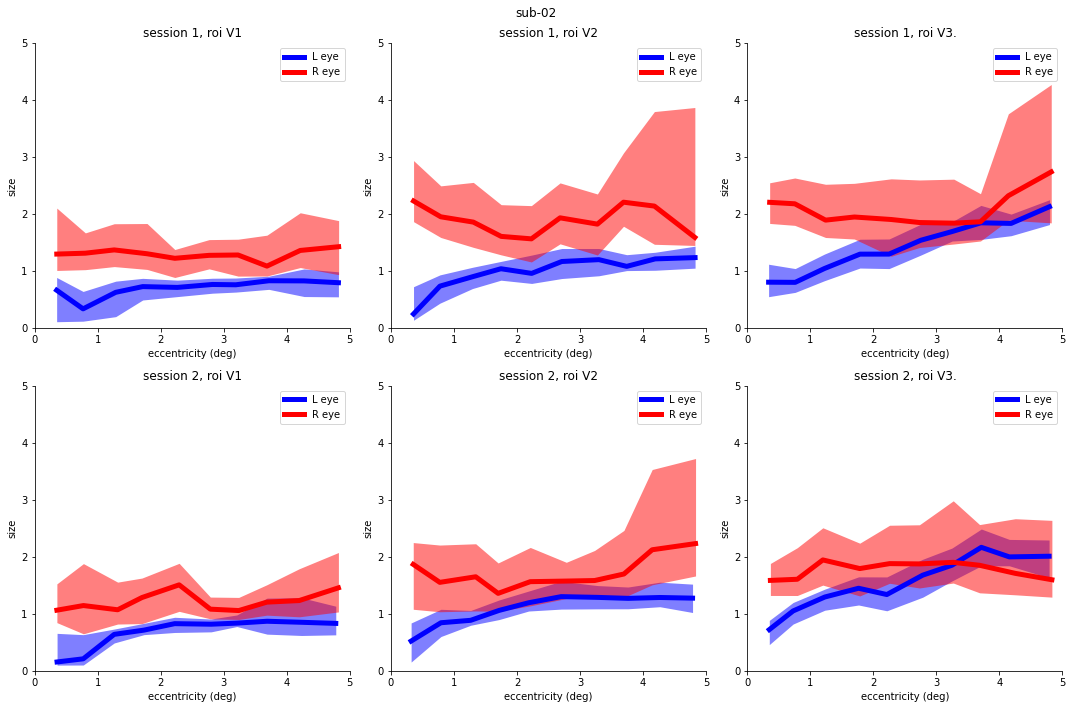

In [67]:
%matplotlib inline
# sns.set_context('paper')
y_param = 'gauss-size_1'
min_rsq = 0.3
y_lim = [0,5]
roi_list = ['b14_V1', 'b14_V2', 'b14_V3.']
for sub in sub_list:
    fig,axs = plt.subplots(2,3)
    fig.set_size_inches(5*3,5*2)
    fig.suptitle(sub)

    for i_roi, roi in enumerate(roi_list):
        for i_ses, ses in enumerate(['1','2']):
            ax = axs[i_ses][i_roi]
            for i_eye, eye in enumerate(['L', 'R']):
                # print(ses)
                # print(roi)
                roi_mask = amb_load_roi(sub, roi)
                th = {
                    f'{eye}_{ses}_gauss-min-rsq':min_rsq,
                    f'{eye}_{ses}_gauss-min-rsq':min_rsq,
                    f'{eye}_{ses}_csf-min-rsq':min_rsq,

                }
                prf_multi[sub].scatter(
                    px=f'{eye}_{ses}_gauss-ecc',
                    py=f'{eye}_{ses}_{y_param}',
                    do_line=True,
                    bins=np.linspace(0,5,11),
                    do_scatter=False,
                    ax=ax,
                    line_label=f'{eye} eye',
                    th_plus={'roi':roi_mask},
                    line_col = plot_cols[f'{eye}E'],
                    x_lim=[0,5],
                    y_lim=y_lim,
                    do_bars=False, 
                    do_shade=True, 
                    err_type='pc-75'
                )
                ax.set_title(f'session {ses}, roi {roi.replace("b14_", "")}')
                # ax.set_yscale('log')
                # ax.set_aspect('equal')
                # ax.set_axis('square') # change to be square
                ax.set_xlabel(f'{p2plot_nice["ecc"]}')
                ax.set_ylabel(f'{p2plot_nice[y_param.split("-")[-1]]}')
    fig.set_tight_layout('tight')

    fig_saver.add_img(fig, f'ECC_PLOT_{sub}-ecc_vs_size', ow=True)

# TIMESERIES

<Figure size 432x288 with 0 Axes>

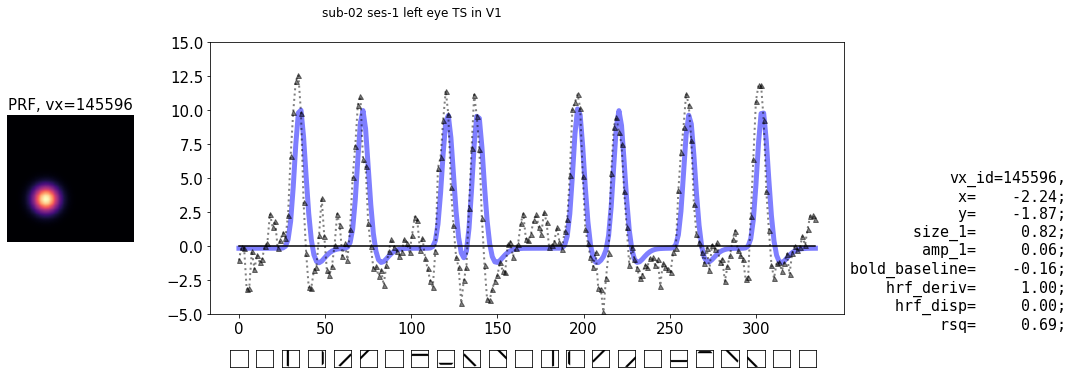

<Figure size 432x288 with 0 Axes>

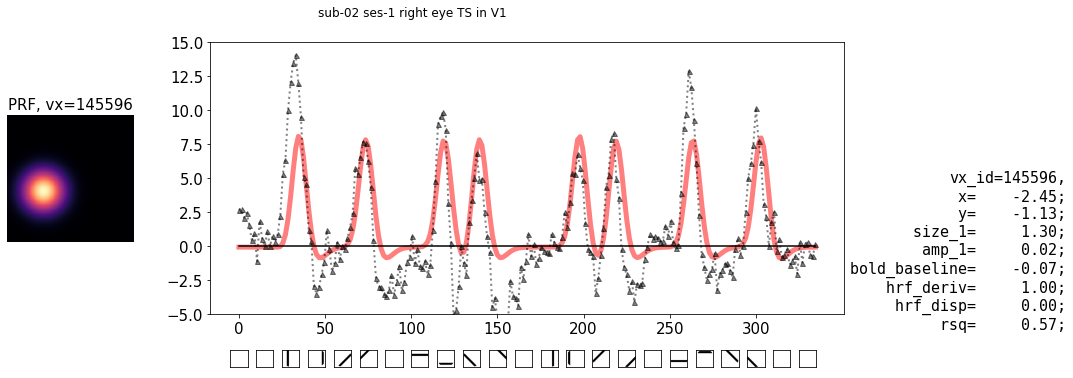

In [80]:
# Find nice voxel...
# roi = 'b14_V1'
# min_rsq = 0.4
# roi_mask = amb_load_roi(sub, roi)
# vx_mask = prf_multi[sub].return_vx_mask({
#     'L_1_csf-min-rsq'       : min_rsq,
#     'L_1_gauss-min-rsq'     : min_rsq,
#     'L_1_gauss-bound-ecc'   : [0.5,3],
#     'R_1_csf-min-rsq'       : min_rsq,
#     'R_1_gauss-min-rsq'     : min_rsq,
#     'R_1_gauss-bound-ecc'   : [0.5,3],
#     'roi'           : roi_mask,
# })  

# print(np.where(vx_mask))
idx = 145596
fig = plt.figure()
prf_multi[sub].prf_obj['L_1_gauss'].prf_ts_plot(
    idx, ts_kwargs=dict(color=plot_cols['LE']))
fig =plt.gcf()
ts_ax = fig.get_children()[2]
ts_ax.set_ylim(-5,15)
fig.suptitle(f'{sub} ses-1 left eye TS in V1')
fig_saver.add_img(fig, f'TS_PLOT_{sub}-LE_timeseries')

fig = plt.figure()
prf_multi[sub].prf_obj['R_1_gauss'].prf_ts_plot(
    idx, ts_kwargs=dict(color=plot_cols['RE']))
fig =plt.gcf()
ts_ax = fig.get_children()[2]
ts_ax.set_ylim(-5,15)
fig.suptitle(f'{sub} ses-1 right eye TS in V1')
fig_saver.add_img(fig, f'TS_PLOT_{sub}-RE_timeseries')


# QCSF

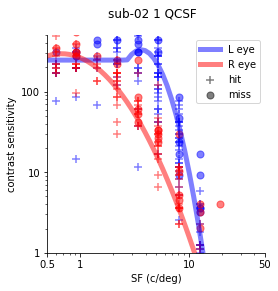

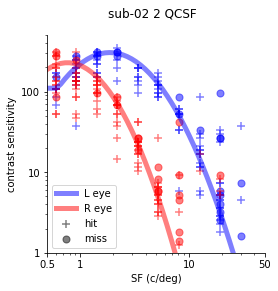

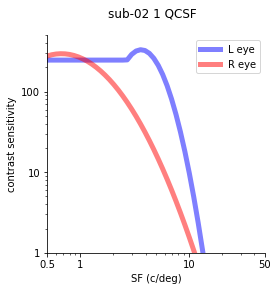

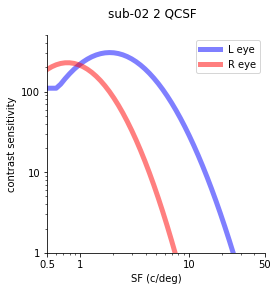

In [69]:
# Find nice voxel...

for sub in sub_list:
    for i_ses,ses in enumerate([1, 2]):
        fig,ax = plt.subplots(1)
        fig.set_size_inches(4,4)
        fig.suptitle(f'{sub} {ses} QCSF')
        for eye in ['L', 'R']: # , 'R']:
            ncsf_plt_qCSF(
                qCSF_info[sub][f'ses-{ses}'][eye],
                ax=ax,
                line_label=f'{eye} eye',
                line_col=plot_cols[f'{eye}E'],
                do_response=True, 
            )
        ax.scatter(-1, -1, s=50, color='k', marker='+', alpha=0.5, label='hit')
        ax.scatter(-1, -1, s=50, color='k', marker='o', alpha=0.5, label='miss')

        plt.legend()
        fig_saver.add_img(fig, f'QCSF_PLOT_{sub}-{ses}_hitmiss')


for sub in sub_list:
    for i_ses,ses in enumerate([1, 2]):
        fig,ax = plt.subplots(1)
        fig.set_size_inches(4,4)
        fig.suptitle(f'{sub} {ses} QCSF')
        for eye in ['L', 'R']: # , 'R']:
            ncsf_plt_qCSF(
                qCSF_info[sub][f'ses-{ses}'][eye],
                ax=ax,
                line_label=f'{eye} eye',
                line_col=plot_cols[f'{eye}E'],
                do_response=False, 
            )
        ax.set_box_aspect(1)
        plt.legend()
        fig_saver.add_img(fig, f'QCSF_PLOT_{sub}-{ses}_line_only')        


# NCSF 

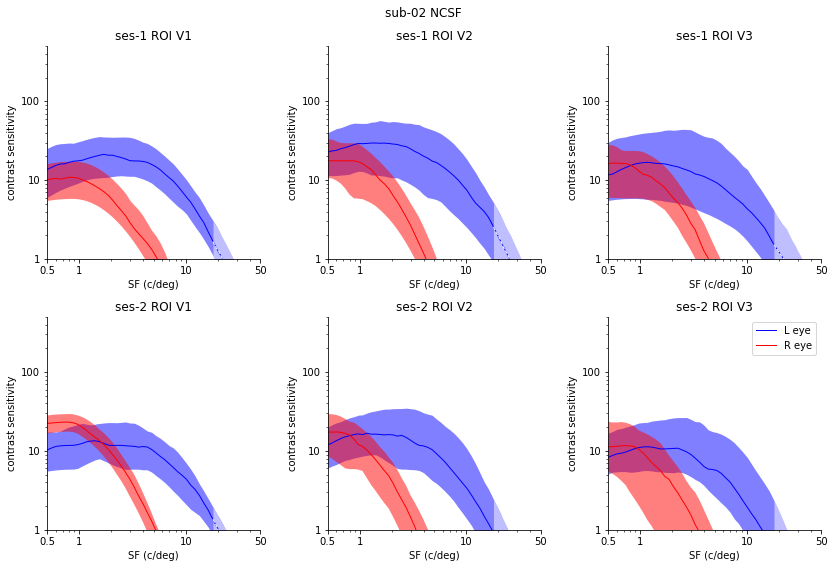

In [70]:
# Find nice voxel...
roi_list = ['b14_V1', 'b14_V2', 'b14_V3.']
min_rsq = 0.3
max_ecc = 5

for sub in sub_list:
    fig,axs = plt.subplots(2,3)
    fig.set_size_inches(12,8)
    fig.suptitle(f'{sub} NCSF')
    
    for i_ses,ses in enumerate([1, 2]):
        for i_roi,roi in enumerate(roi_list): 
            roi_mask = amb_load_roi(sub, roi)            
            for eye in ['L', 'R']: # , 'R']:
                vx_mask = prf_multi[sub].return_vx_mask({
                    f'{eye}_{ses}_csf-min-rsq'          : min_rsq,
                    f'{eye}_{ses}_gauss-min-rsq'        : min_rsq,
                    f'{eye}_{ses}_gauss-max-ecc'        : max_ecc,
                    'roi'           : roi_mask,
                })  

                params = prf_multi[sub].prf_obj[f'{eye}_{ses}_csf'].pd_params.iloc[vx_mask]

                ncsfplt_csf_curve(
                    ax=axs[i_ses][i_roi],
                    params=params, 
                    line_label=f'{eye} eye',
                    line_col=plot_cols[f'{eye}E'],
                )
                nice_roi = roi.replace('b14_', '').replace('.', '')
                axs[i_ses][i_roi].set_title(f'ses-{ses} ROI {nice_roi}')
    axs[i_ses][i_roi].legend()
    fig.set_tight_layout('tight')
    fig_saver.add_img(fig, f'NCSF_PLOT_{sub}')        

# SURFACES

In [71]:
# START LOGGING THIS NOTEBOOK
pyc_file = '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/pyc_statics/'
if not os.path.exists(pyc_file):
    os.mkdir(pyc_file)
else:
    os.system(f'rm -r {pyc_file}')
    os.mkdir(pyc_file)


p_cmap = {
    'crf_exp'   : 'cool_log', 
    'SFp'       : 'viridis',
    'aulcsf'    : 'aulcsf', 
    'rsq'       : 'plasma',
    'ecc'       : 'ecc2', #'ecc2', 
    'pol'       : 'marco_pol',
    'size_1'    : 'viridis_log',
    'CSp'       : 'viridis_log',        
    'sfmax'       : 'viridis_log',
    'corr'      : 'RdBu_r',

}
p_bounds = {
    'SFp'     : [0,3],
    'crf_exp' : [.1, 5],
    'aulcsf'  : [0,150],
    'rsq'     : [0.1,1],
    'ecc'     : [0,5],
    'pol'     : [-np.pi, np.pi],    
    'size_1'   : [0, 5],
    'sfmax'   : [0, 50],
    'CSp'  : [0, 100],
    'corr' : [-1,1],
}
roi_list = ['b14_V1', 'b14_V2', 'b14_V3.', 'b14_V3a', 'b14_V3b', 'b14_LO1', 'b14_LO2'] # 'all']
from dag_prf_utils.pycortex import *
# from linescanning.pycortex import *
set_ctx_path(
    p='/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/pycortex',
)


'/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/pycortex'

In [72]:

p_list = ['gauss-ecc', 'gauss-pol', 'gauss-rsq']    
for sub in sub_list:
    sub_pyc_file = opj(pyc_file, sub)
    if not os.path.exists(sub_pyc_file):
        os.mkdir(sub_pyc_file)
    pm = PyctxMaker(
        sub = sub,
        fs_dir = '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer',
        output_dir = sub_pyc_file,
        )
    for p_full in p_list:
        for ses in ['1', '2']:
            for eye in ['L', 'R']:
                p_mod, p_par = p_full.split('-')
                if p_mod=='csf':
                    th = {
                        f'{eye}_{ses}_csf-min-rsq':.1,
                        f'{eye}_{ses}_gauss-min-rsq':.1,
                        f'{eye}_{ses}_gauss-max-ecc':5,
                        }
                else:
                    th = {
                        f'{eye}_{ses}_gauss-min-rsq':.1,
                        f'{eye}_{ses}_gauss-max-ecc':5,
                        }

                full_param_keye = f'{eye}_{ses}_{p_mod}-{p_par}'
                if p_par=='corr':
                    data = run_corr[sub][f'{eye}_{ses}_{p_mod}']
                    vx_mask = np.ones_like(data, dtype=bool)
                else:
                    data = prf_multi[sub].pd_params[full_param_keye].to_numpy()
                    vx_mask = prf_multi[sub].return_vx_mask(th)
                surf_name = f'Eye-{eye}_ses-{ses}_{p_mod}-{p_par}'
                pm.add_vertex_obj(
                    data=data, 
                    data_mask=vx_mask,
                    cmap = p_cmap[p_par], 
                    vmin=p_bounds[p_par][0], 
                    vmax=p_bounds[p_par][1], 
                    surf_name=f'{surf_name}',    
                    under_surf='curv', 
                )
    pm.add_vertex_obj(
        data=np.ones_like(vx_mask), 
        surf_name='benson14_roi',    
        under_surf='curv', 
        roi_list = roi_list,
    )    


/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/pycortex/sub-02


Started server on port 49389
Stopping server


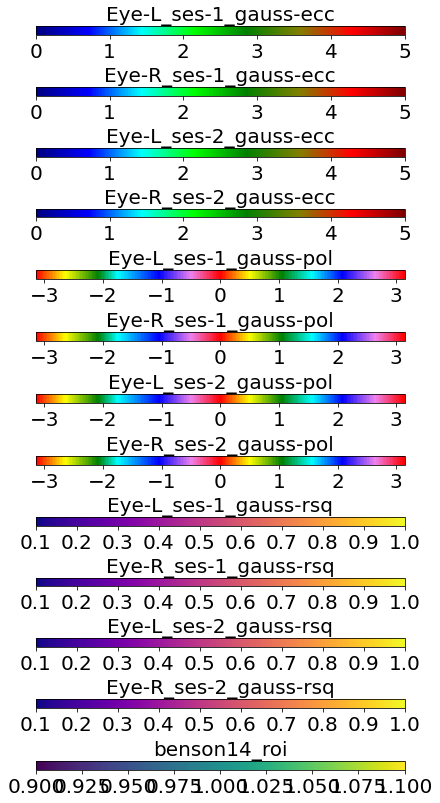

In [73]:
pm.return_pyc_saver(
    output_dir=sub_pyc_file,
    azimuth=180,
    altitude=90, 
    radius=300,
    width=1800,height=1800,

)


In [75]:
fig_dir = opj(fig_saver.path, 'surfs', sub)
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
else:
    os.system(f'rm -r {fig_dir}')
    os.makedirs(fig_dir)

pm.pyc.size = [1800,1800]
pm.pyc.save_all(
    fig_dir=fig_dir, 
    add_cms=True, 
)

saving Eye-L_ses-1_gauss-ecc
saving Eye-R_ses-1_gauss-ecc
saving Eye-L_ses-2_gauss-ecc
saving Eye-R_ses-2_gauss-ecc
saving Eye-L_ses-1_gauss-pol
saving Eye-R_ses-1_gauss-pol
saving Eye-L_ses-2_gauss-pol
saving Eye-R_ses-2_gauss-pol
saving Eye-L_ses-1_gauss-rsq
saving Eye-R_ses-1_gauss-rsq
saving Eye-L_ses-2_gauss-rsq
saving Eye-R_ses-2_gauss-rsq
saving benson14_roi


In [85]:
fig_saver.add_img(pm.pyc.cm_fig, 'color_maps')

In [86]:
pm.pyc.js_handle.controls

<JS: window.viewer.controls>

In [ ]:
fig.saver.save